In [31]:
import numpy as np
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.wcs import WCS
from astropy.io import fits

from matplotlib.colors import LogNorm

from astropy.utils.data import download_file

import warnings

catalog_path='/Users/EvanB.LAPTOP-8CHCIOMA/Downloads/'

#A100-NSA Catalog
myTab=Table.read(catalog_path+'a100-nsa-for-adap.fits')
myTab.info

<Table length=39098>
         name           dtype   shape     class     n_bad
---------------------- ------- ------- ------------ -----
                   AGC   int64         MaskedColumn     0
                  Name  bytes8         MaskedColumn 24678
           OrigSrcName bytes26         MaskedColumn 24678
             HISrcName bytes17         MaskedColumn 24678
              RAdeg_HI float64               Column     0
             DECdeg_HI float64               Column     0
              RAdeg_OC float64               Column     0
             DECdeg_OC float64               Column     0
             RAdeg_Use float64               Column     0
            DECdeg_Use float64               Column     0
                Vhelio   int64         MaskedColumn     0
                  sigV   int64         MaskedColumn     0
                   W50   int64         MaskedColumn     0
               sigWtot   int64         MaskedColumn     0
              sigWstat   int64         MaskedColumn

In [2]:
# Cut Sample

# SNR cut: GALEX NUV or WISE 12um SNR > 20
snrmin = 20
W3snr = myTab['w3_nanomaggies']
W3snr_ivar = myTab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
W3flag = (W3snr>snrmin) | (myTab['W3SNR']>snrmin)  
GALEXsnr = myTab['NMGY'][:,1]
GALEXsnr_ivar = myTab['NMGY_IVAR'][:,1]
GALEXsnr = GALEXsnr*np.sqrt(GALEXsnr_ivar)
NUVflag = GALEXsnr>snrmin
SNRflag20 = W3flag | NUVflag

# Size cut: r-band effective radii greater than two pixels (> 5.500" ) in the unWISE images
radmin = 6.500
rad_eff1 = myTab['SERSIC_TH50']
rad_eff2 = myTab['petroR50_r']
sizeflag65 = (rad_eff1>radmin) | (rad_eff2>radmin)

# Redshift cut: 0.002 < z < 0.025
zmin=0.002
zmax=0.025
redshift = myTab['ZDIST']
vhelio = myTab['Vhelio']
redshiftflag = (redshift>zmin) & (redshift<zmax)
vhelioflag = (vhelio>(zmin*3e5)) & (vhelio<(zmax*3e5))
zflag = redshiftflag | vhelioflag 

# Apply cuts
NSFcut = SNRflag20 & sizeflag65 & zflag
cuttab = myTab[NSFcut]

In [3]:
#Cut Sample W3 Luminosity

#Finding flux in nmgy to W/m^2/Hz
cutw3nmgy = cuttab['w3_nanomaggies']
cutw3Jy = cutw3nmgy*(3.631*10**(-6))
cutw3Flux = cutw3Jy*10**(-26)

#Finding distance
H0 = 2.3*10**(-18) #/s
c = 3*10**8 #m/s
cutz = cuttab['ZDIST']

v = cutz*c 
d = v/H0

#Flux of Sun
Msunab = 8.48
Fsun = 3631*10**(Msunab/-2.5) #Jy
Fsun2 = Fsun*10**(-26) #W/m^2/Hz
r = 10*3*10**17 #10*3*10**17 #m   #1.5*10**(11)
Lsun = Fsun2*(4*np.pi*r**2)

#Finding luminosity in Solar luminosities
cutLw3 = cutw3Flux*(4*np.pi*d**2)/Lsun

In [4]:
#Finding flux in nmgy to W/m^2/Hz
w3nmgy = myTab['w3_nanomaggies']
w3Jy = w3nmgy*(3.631*10**(-6))
w3Flux = w3Jy*10**(-26)

In [5]:
#Finding distance
H0 = 2.3*10**(-18) #/s
c = 3*10**8 #m/s
z = myTab['ZDIST']

v = z*c 
d = v/H0

In [6]:
#Flux of Sun
Msunab = 8.48
Fsun = 3631*10**(Msunab/-2.5) #Jy
Fsun2 = Fsun*10**(-26) #W/m^2/Hz
r = 10*3*10**17 #m
Lsun = Fsun2*(4*np.pi*r**2)

In [7]:
#Finding luminosity in Solar luminosities
Lw3 = w3Flux*(4*np.pi*d**2)/Lsun

In [42]:
#Cut Sample W3 Luminosity

#Finding flux in nmgy to W/m^2/Hz
cutw1nmgy = cuttab['w1_nanomaggies']
cutw1Jy = cutw1nmgy*(3.631*10**(-6))
cutw1Flux = cutw1Jy*10**(-26)

#Finding distance
H0 = 2.3*10**(-18) #/s
c = 3*10**8 #m/s
cutz = cuttab['ZDIST']

v = cutz*c 
d = v/H0

#Flux of Sun
Msunab = 8.48
Fsun = 3631*10**(Msunab/-2.5) #Jy
Fsun2 = Fsun*10**(-26) #W/m^2/Hz
r = 10*3*10**17 #10*3*10**17 #m   #1.5*10**(11)
Lsun = Fsun2*(4*np.pi*r**2)

#Finding luminosity in Solar luminosities
cutLw1 = cutw1Flux*(4*np.pi*d**2)/Lsun

## Redshift vs. W1 Luminosity colored by W3 SNR

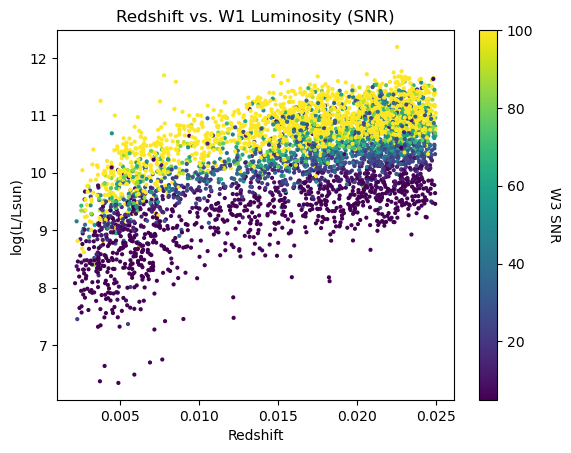

In [47]:
#Plot W3 luminosity vs redshift colored by SNR
W3snr = cuttab['w3_nanomaggies']
W3snr_ivar = cuttab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
ccode = W3snr

plt.scatter(cutz,np.log10(cutLw1),s=4,c=ccode,cmap='viridis',clim=(5,100))
plt.title('Redshift vs. W1 Luminosity (SNR)')
plt.ylabel('log(L/Lsun)')
plt.xlabel('Redshift')
cbar = plt.colorbar()
cbar.set_label('W3 SNR',rotation=270,labelpad=20)

warnings.filterwarnings('ignore',category=RuntimeWarning)

## Redshift vs. W3 Luminosity Plots for (SNR>20 and size>6.5") Cut

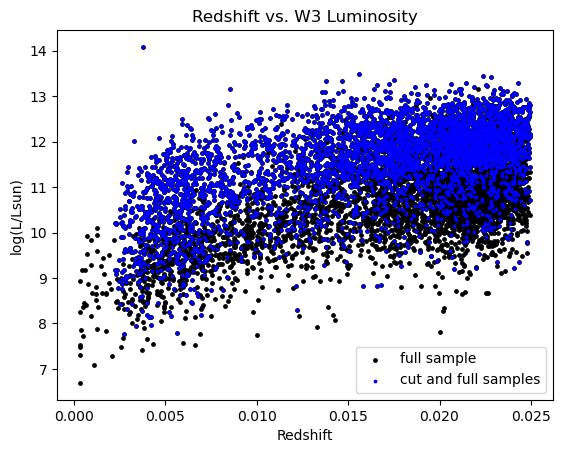

In [20]:
#Plot full and cut sample W3 luminosity vs. redshift

fig, ax = plt.subplots()
plt.scatter(z,np.log10(Lw3),s=6,color='black',label='full sample')
plt.scatter(cutz,np.log10(cutLw3),s=3,color='blue',label='cut and full samples')
plt.legend()
plt.title('Redshift vs. W3 Luminosity')
plt.ylabel('log(L/Lsun)')
plt.xlabel('Redshift')

warnings.filterwarnings('ignore',category=RuntimeWarning)

#### Here we can see where the cut sample and full catalogue overlap. The cut sample favors galaxies with high luminosities which is to be expected because of the SNR > 20 cut. The lower luminosity galaxies included in the cut sample likely had a large size meaning they are included despite the low surface brightness. We can also see the redshift cutoff at z=0.002. 

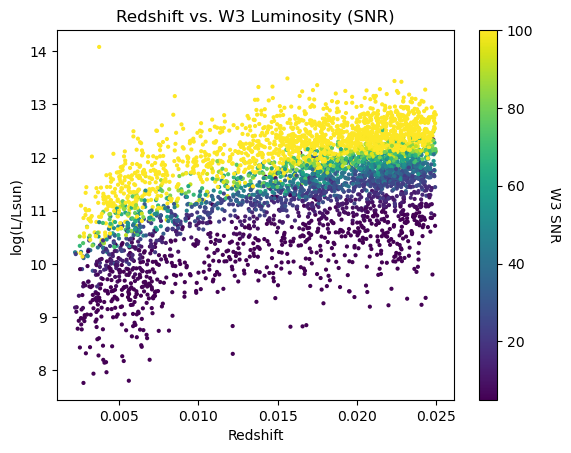

In [45]:
#Plot W3 luminosity vs redshift colored by SNR
W3snr = cuttab['w3_nanomaggies']
W3snr_ivar = cuttab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
ccode = W3snr

plt.scatter(cutz,np.log10(cutLw3),s=4,c=ccode,cmap='viridis',clim=(5,100))
plt.title('Redshift vs. W3 Luminosity (SNR)')
plt.ylabel('log(L/Lsun)')
plt.xlabel('Redshift')
cbar = plt.colorbar()
cbar.set_label('W3 SNR',rotation=270,labelpad=20)

warnings.filterwarnings('ignore',category=RuntimeWarning)

#### The color here reflects the SNR. It looks like galaxies with higher luminosities have a higher SNR as expected.

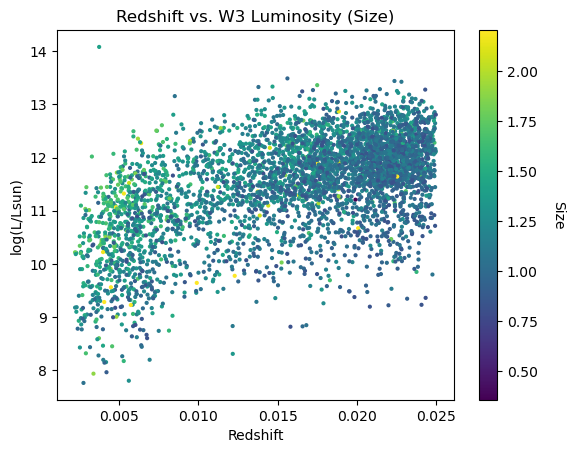

In [46]:
#Plot W3 luminosity vs redshift colored by size
size = cuttab['SERSIC_TH50']
ccode = np.log10(size)

plt.scatter(cutz,np.log10(cutLw3),s=4,c=ccode,cmap='viridis')
plt.title('Redshift vs. W3 Luminosity (Size)')
plt.ylabel('log(L/Lsun)')
plt.xlabel('Redshift')
cbar = plt.colorbar()
cbar.set_label('Size',rotation=270,labelpad=20)

warnings.filterwarnings('ignore',category=RuntimeWarning)

#### The color here reflects the size of the galaxies. The trend here is less apparent but larger galaxies do appear to be concentrated at lower redshifts as would be expected since they are closer.

## Cuts vs. Full Sample Plots

In [11]:
# SNR cut: GALEX NUV or WISE 12um SNR > 20
snrmin = 20
W3snr = myTab['w3_nanomaggies']
W3snr_ivar = myTab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
W3flag = (W3snr>snrmin) | (myTab['W3SNR']>snrmin)  
GALEXsnr = myTab['NMGY'][:,1]
GALEXsnr_ivar = myTab['NMGY_IVAR'][:,1]
GALEXsnr = GALEXsnr*np.sqrt(GALEXsnr_ivar)
NUVflag = GALEXsnr>snrmin
SNRflag20 = W3flag | NUVflag

In [12]:
# Size cut: r-band effective radii greater than two pixels (> 5.500" ) in the unWISE images
radmin = 5.500
rad_eff1 = myTab['SERSIC_TH50']
rad_eff2 = myTab['petroR50_r']
sizeflag55 = (rad_eff1>radmin) | (rad_eff2>radmin)

In [13]:
# SNR cut: GALEX NUV or WISE 12um SNR > 20
snrmin = 10
W3snr = myTab['w3_nanomaggies']
W3snr_ivar = myTab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
W3flag = (W3snr>snrmin) | (myTab['W3SNR']>snrmin)  
GALEXsnr = myTab['NMGY'][:,1]
GALEXsnr_ivar = myTab['NMGY_IVAR'][:,1]
GALEXsnr = GALEXsnr*np.sqrt(GALEXsnr_ivar)
NUVflag = GALEXsnr>snrmin
SNRflag10 = W3flag | NUVflag

In [14]:
# Size cut: r-band effective radii greater than two pixels (> 6.500" ) in the unWISE images
radmin = 6.500
rad_eff1 = myTab['SERSIC_TH50']
rad_eff2 = myTab['petroR50_r']
sizeflag65 = (rad_eff1>radmin) | (rad_eff2>radmin)

In [15]:
# Redshift cut: 0.002 < z < 0.025
zmin=0.002
zmax=0.025
redshift = myTab['ZDIST']
vhelio = myTab['Vhelio']
redshiftflag = (redshift>zmin) & (redshift<zmax)
vhelioflag = (vhelio>(zmin*3e5)) & (vhelio<(zmax*3e5))
zflag = redshiftflag | vhelioflag 

In [16]:
# Apply cuts
NSFcut1 = SNRflag20 & sizeflag55 & zflag
cuttab1 = myTab[NSFcut1]

NSFcut2 = SNRflag10 & sizeflag55 & zflag
cuttab2 = myTab[NSFcut2]

NSFcut3 = SNRflag10 & sizeflag65 & zflag
cuttab3 = myTab[NSFcut3]

NSFcut4 = SNRflag20 & sizeflag65 & zflag
cuttab4 = myTab[NSFcut4]

In [17]:
# Function to find luminosities for specified cuts
def W3Lum(cut):
    H0 = 2.3*10**(-18) #/s
    c = 3*10**8 #m/s
    z = cut['ZDIST']

    v = z*c 
    d = v/H0
    
    w3nmgy = cut['w3_nanomaggies']
    w3Jy = w3nmgy*(3.631*10**(-6))
    w3Flux = w3Jy*10**(-26)
    
    Lw3 = w3Flux*(4*np.pi*d**2)/Lsun
    return Lw3

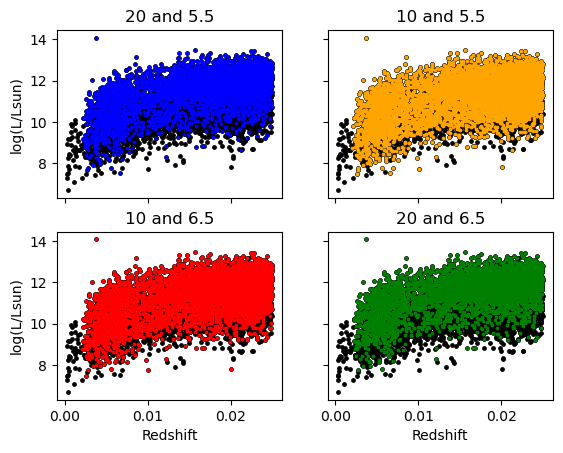

In [18]:
# Plot cut samples and full sample
z = myTab['ZDIST']
z1 = cuttab1['ZDIST']
z2 = cuttab2['ZDIST']
z3 = cuttab3['ZDIST']
z4 = cuttab4['ZDIST']

fig, axs = plt.subplots(2,2)
axs[0,0].scatter(z,np.log10(Lw3),s=6,color='black',label='full sample')
axs[0,0].scatter(z1,np.log10(W3Lum(cuttab1)),s=3,color='blue',label='20 and 5.5')
axs[0,0].set_title('20 and 5.5')

axs[0,1].scatter(z,np.log10(Lw3),s=6,color='black',label='full sample')
axs[0,1].scatter(z2,np.log10(W3Lum(cuttab2)),s=3,color='orange',label='10 and 5.5')
axs[0,1].set_title('10 and 5.5')

axs[1,0].scatter(z,np.log10(Lw3),s=6,color='black',label='full sample')
axs[1,0].scatter(z3,np.log10(W3Lum(cuttab3)),s=3,color='red',label='10 and 6.5')
axs[1,0].set_title('10 and 6.5')

axs[1,1].scatter(z,np.log10(Lw3),s=6,color='black',label='full sample')
axs[1,1].scatter(z4,np.log10(W3Lum(cuttab4)),s=3,color='green',label='20 and 6.5')
axs[1,1].set_title('20 and 6.5')

for ax in axs.flat:
    ax.set(xlabel='Redshift', ylabel='log(L/Lsun)')

for ax in axs.flat:
    ax.label_outer()

warnings.filterwarnings('ignore',category=RuntimeWarning)

#### These four plots show how much of the full dataset each cut represents. Orange is the largest of the cut sets while green is the smallest.

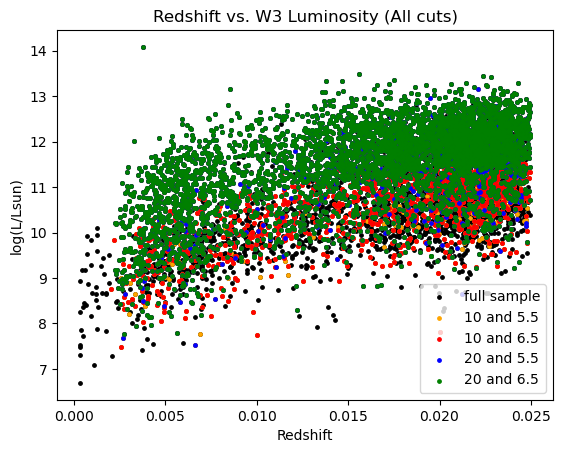

In [19]:
# Plot cut samples and full sample
z = myTab['ZDIST']
z1 = cuttab1['ZDIST']
z2 = cuttab2['ZDIST']
z3 = cuttab3['ZDIST']
z4 = cuttab4['ZDIST']

fig, ax = plt.subplots()
plt.scatter(z,np.log10(Lw3),s=6,color='black',label='full sample')


plt.scatter(z2,np.log10(W3Lum(cuttab2)),s=6,color='orange',label='10 and 5.5')

plt.scatter(z3,np.log10(W3Lum(cuttab3)),s=6,color='red',label='10 and 6.5')

plt.scatter(z1,np.log10(W3Lum(cuttab1)),s=6,color='blue',label='20 and 5.5')

plt.scatter(z4,np.log10(W3Lum(cuttab4)),s=6,color='green',label='20 and 6.5')

plt.title('Redshift vs. W3 Luminosity (All cuts)')
plt.xlabel('Redshift')
plt.ylabel('log(L/Lsun)')

plt.legend()


warnings.filterwarnings('ignore',category=RuntimeWarning)

#### This plot shows all of cut samples from the previous plot plotted on top of each other. All the cuts appear to be concentrated at higher luminosities with some having more or less data points at lower luminosities. The data sets appear to be distributed similarly and have a lot of overlap, the largest data set does not appear to have that many more galaxies at lower luminosities and higher redshifts than the smallest data set.